# Model evaluation and subnotifications

---

**Active cases calculation**

- Sum of new daily cases reported over the last $\Delta t$ = `infectious period` days
- Get daily recovered by the difference of cumulative cases - active cases - cummulative deaths
- ***Considerations:*** We are overestimating active cases not accounting for recovered and deaths in mean infection time -  how to manage this?

**Current model evaluation**
- Model evaluation on current version (with initial active cases): MSE over last 7 days
- ***Considerations***: could we have a better metric giving that we have data from a small window of time (~1 month) and changes of protocols over the first days?


**Subnotification**
- Ajusting active cases over the cumulative deaths to get the expected %CFR ($2\%$ of total infected)
- Evaluation of the model with adjustment
- ***Considerations***: by increasing active cases with subnotification, the magnitude of the error also increases - we should consider a relative metric

**Test_delay**

- Is it necessary?

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-packages" data-toc-modified-id="Import-packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import packages</a></span></li><li><span><a href="#Model-&amp;-simulation-parameters" data-toc-modified-id="Model-&amp;-simulation-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model &amp; simulation parameters</a></span></li><li><span><a href="#Import-data:-municipality-cases" data-toc-modified-id="Import-data:-municipality-cases-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Import data: municipality cases</a></span><ul class="toc-item"><li><span><a href="#Choose-city" data-toc-modified-id="Choose-city-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Choose city</a></span></li></ul></li><li><span><a href="#Calculate-active-&amp;-recovered-cases" data-toc-modified-id="Calculate-active-&amp;-recovered-cases-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculate active &amp; recovered cases</a></span></li><li><span><a href="#Model-evaluation" data-toc-modified-id="Model-evaluation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model evaluation</a></span><ul class="toc-item"><li><span><a href="#Set-population-parameters" data-toc-modified-id="Set-population-parameters-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Set population parameters</a></span></li><li><span><a href="#Run-curent-model" data-toc-modified-id="Run-curent-model-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Run curent model</a></span></li><li><span><a href="#Get-active-cases-&amp;-deaths-estimated-and-observed-in-evaluation-days" data-toc-modified-id="Get-active-cases-&amp;-deaths-estimated-and-observed-in-evaluation-days-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Get active cases &amp; deaths estimated and observed in evaluation days</a></span></li><li><span><a href="#Calculate-mean-error" data-toc-modified-id="Calculate-mean-error-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Calculate mean error</a></span></li></ul></li><li><span><a href="#Calculate-&amp;-ajust-by-notification-rate" data-toc-modified-id="Calculate-&amp;-ajust-by-notification-rate-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Calculate &amp; ajust by notification rate</a></span><ul class="toc-item"><li><span><a href="#Deaths-from-past-week" data-toc-modified-id="Deaths-from-past-week-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Deaths from past week</a></span></li><li><span><a href="#Project-actual-I3-that-gives-this-level-of-deaths" data-toc-modified-id="Project-actual-I3-that-gives-this-level-of-deaths-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Project actual I3 that gives this level of deaths</a></span></li><li><span><a href="#Estimated-notification-rate" data-toc-modified-id="Estimated-notification-rate-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Estimated notification rate</a></span></li></ul></li><li><span><a href="#Evaluation-with-subnotification" data-toc-modified-id="Evaluation-with-subnotification-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Evaluation with subnotification</a></span><ul class="toc-item"><li><span><a href="#Change-to-initial-cases-ajusted-by-subnotification" data-toc-modified-id="Change-to-initial-cases-ajusted-by-subnotification-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Change to initial cases ajusted by subnotification</a></span></li><li><span><a href="#Run-model-with-initial-cases-ajusted" data-toc-modified-id="Run-model-with-initial-cases-ajusted-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Run model with initial cases ajusted</a></span></li><li><span><a href="#Metric-evaluation" data-toc-modified-id="Metric-evaluation-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Metric evaluation</a></span></li><li><span><a href="#Is-it-better-than-our-current-version?" data-toc-modified-id="Is-it-better-than-our-current-version?-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Is it better than our current version?</a></span></li></ul></li></ul></div>

## Import packages

In [45]:
import sys
sys.path.append("..")
sys.path.append("../src")

In [46]:
%reload_ext autoreload
%autoreload 2

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH, THEMES_PATH

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999

import warnings

warnings.filterwarnings('ignore')

# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Centering and fixing title
def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))

# Adding custom colorscales (to add one: themes/custom_colorscales.yaml)
import yaml
custom_colorscales = yaml.load(open(THEMES_PATH / 'custom_colorscales.yaml', 'r'))
cf.colors._custom_scales['qual'].update(custom_colorscales)
cf.colors.reset_scales()

# Setting cuffilinks template (use it with .iplot(theme='custom')
cf.themes.THEMES['custom'] = yaml.load(open(THEMES_PATH / 'cufflinks_template.yaml', 'r'))

## Model & simulation parameters

In [47]:
config = yaml.load(open('../src/configs/config.yaml', 'r'))
config['br']['seir_parameters']

{'mild_duration': 6,
 'severe_duration': 6,
 'critical_duration': 8,
 'fatality_ratio': 0.02,
 'doubling_rate': 1.15,
 'incubation_period': 5,
 'i1_percentage': 0.855,
 'i2_percentage': 0.12,
 'i3_percentage': 0.025,
 'infected_health_care_proportion': 0.05}

In [48]:
config['simulator']

{'max_days': 90,
 'scenarios': {'worst': {'nothing': {'R0': 3.97},
   'isolation': {'R0': 1.31},
   'lockdown': {'R0': 0.37},
   'test_delay': 7},
  'best': {'nothing': {'R0': 3.74},
   'isolation': {'R0': 1.21},
   'lockdown': {'R0': 0.28},
   'test_delay': 4}}}

## Import data: municipality cases 

In [49]:
cases = pd.read_csv(config['br']['cases']['url'])
cases['date'] = pd.to_datetime(cases['date'])

cases.head()

,city,city_ibge_code,date,estimated_population_2019,is_repeated,is_last,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,place_type,state,new_confirmed,new_deaths
0,São Paulo,3550308.0,2020-02-25,12252023.0,False,False,1,0.00816,2020-02-25,NaN,0,city,SP,0,0
1,NaN,35.0,2020-02-25,45919049.0,False,False,1,0.00218,2020-02-25,NaN,0,state,SP,0,0
2,São Paulo,3550308.0,2020-02-26,12252023.0,False,False,1,0.00816,2020-02-26,NaN,0,city,SP,0,0
3,NaN,35.0,2020-02-26,45919049.0,False,False,1,0.00218,2020-02-26,NaN,0,state,SP,0,0
4,São Paulo,3550308.0,2020-02-27,12252023.0,False,False,1,0.00816,2020-02-27,NaN,0,city,SP,0,0


### Choose city

In [50]:
city = 'Rio de Janeiro'
state = 'RJ'

In [51]:
df_city = cases[(cases['city'] == city) & (cases['state'] == state)]

## Calculate active & recovered cases

- We calculate the active cases $I(t)$ in $T$ by the sum of new cases from the last days in $\Delta t$ = severe + critical infectious period:

$$ I(T) = \sum_{t = T - \Delta}^{T} I^{t} $$

In [52]:
infectious_period = config['br']['seir_parameters']['severe_duration'] + \
                    config['br']['seir_parameters']['critical_duration']
infectious_period

14

In [53]:
df_city['estimate_active_cases'] = df_city['new_confirmed'].rolling(min_periods=1, window=14).sum()
df_city['estimate_recovered'] = df_city['last_available_confirmed'] - \
                               df_city['estimate_active_cases'] - \
                               df_city['last_available_deaths']

In [54]:
df_city.sort_values(by='date').set_index('date')[['last_available_confirmed', 
                                                  'last_available_deaths', 
                                                  'estimate_active_cases', 
                                                  'estimate_recovered']].iplot(
    title='Active vs cumulative cases in {}'.format(city),
    yTitle='Number of cases',
    colorscale='my_colors',
    theme='custom', width=5
)

## Model evaluation

In [55]:
evaluation_days = 7 # our model start on next day

In [56]:
import datetime
evaluation_initial = df_city[cases['date'] == (cases['date'].iloc[-1] - datetime.timedelta(evaluation_days))]
evaluation_initial

,city,city_ibge_code,date,estimated_population_2019,is_repeated,is_last,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,place_type,state,new_confirmed,new_deaths,estimate_active_cases,estimate_recovered
17256,Rio de Janeiro,3304557.0,2020-04-16,6718903.0,False,False,2659,39.57491,2020-04-16,0.0733,195,city,RJ,140,28,1861.0,603.0


### Set population parameters

In [57]:
params = {
    'population': {
        'N': evaluation_initial['estimated_population_2019'].values[0],
        'I': evaluation_initial['estimate_active_cases'].values[0],
        'D': evaluation_initial['last_available_deaths'].values[0],
        'R': evaluation_initial['estimate_recovered'].values[0]
    },
    'strategy':  {
        'isolation': 90,
        'lockdown': 90
    }
}

In [58]:
params['population'], params['strategy']

({'N': 6718903.0, 'I': 1861.0, 'D': 195, 'R': 603.0},
 {'isolation': 90, 'lockdown': 90})

In [59]:
for bound in ['best', 'worst']: # no test delay explicit
    config['simulator']['scenarios'][bound]['test_delay'] = 0

### Run curent model

In [60]:
from model import simulator
dfs = simulator.run_simulation(params['population'], params['strategy'], config)

### Get active cases & deaths estimated and observed in evaluation days

In [61]:
comparison_cols = {'estimate_active_cases': 'I',
                  'last_available_deaths':'D'}

In [62]:
y = df_city[df_city['date'] >= evaluation_initial['date'].values[0]] \
                                                         .set_index('date') \
                                                         .rename(comparison_cols, axis=1)

In [63]:
y_est = dict()
for bound in dfs.keys():
    y_est[bound] = dfs[bound][:evaluation_days+1]
    # Set date index
    y_est[bound].index = y.index
    # Total infected
    y_est[bound]['I'] = y_est[bound]['I1'] + y_est[bound]['I2'] + y_est[bound]['I3']

In [64]:
t = y[['I']].join(y_est['best'][['I']], rsuffix='_best')
t = t.join(y_est['worst'][['I']], rsuffix='_worst')

t.iplot(title='Active daily cases comparision (current model)',
        yTitle='Number of cases', colorscale='my_colors', theme='custom', width=5)

In [65]:
t = y[['D']].join(y_est['best'][['D']], rsuffix='_best')
t = t.join(y_est['worst'][['D']], rsuffix='_worst')

t.iplot(title='Cumulative daily deaths comparision (current model)',
        yTitle='Number of deaths', colorscale='my_colors', theme='custom', width=5)

### Calculate mean error

In [66]:
mse_current = {'best': dict(), 'worst': dict()}

for bound in dfs.keys():
    for category in comparison_cols.values():
        mse_current[bound][category] = np.square(np.subtract(y[category], y_est[bound][category])).mean()

In [67]:
mse_current

{'best': {'I': 905392.9705496377, 'D': 2532.737517633799},
 'worst': {'I': 1152094.873386804, 'D': 2530.541245834625}}

In [68]:
np.sqrt(mse_current['best']['D']), np.sqrt(mse_current['worst']['D'])

(50.32631039162119, 50.30448534509249)

In [69]:
np.sqrt(mse_current['best']['I']), np.sqrt(mse_current['worst']['I'])

(951.5213978411824, 1073.3568248195957)

## Calculate & ajust by notification rate

We have reason to believe that there is less systematic underreporting in deaths than what happens among cases.
- Legally, cause of death needs to be reported and classified in some way in Brazil
- Deaths occur after a temporal progression of the disease, during which there is time to identify and confirm if the person is infected with SARS-CoV-2.


Therefore we propose estimating the actual number of cases by:
- Take the number of deaths per day of the past week
- By inferring that this number is $\mu$% (`frac_critical_to_death`) of the total number of I3 in our model (2.5%*I), project actual number of I3 that produced this number of deaths.
- Adjusting that number temporally to D (`critical_duration`) days before.

### Deaths from past week

In [70]:
y_adjust = y.copy()

In [71]:
y_adjust['D'] 

date
2020-04-16    195
2020-04-17    219
2020-04-18    237
2020-04-19    245
2020-04-20    257
2020-04-21    283
2020-04-22    303
2020-04-23    303
Name: D, dtype: int64

### Project actual I3 that gives this level of deaths

In [72]:
model_params = config['br']['seir_parameters']

frac_critical_to_death = model_params['fatality_ratio'] / model_params['i3_percentage']
frac_critical_to_death

0.7999999999999999

In [73]:
y_adjust['I3'] = y_adjust['D'] / frac_critical_to_death
y_adjust['I'] = y_adjust['I3'] / model_params['i3_percentage']

y_adjust['I']

date
2020-04-16     9750.0
2020-04-17    10950.0
2020-04-18    11850.0
2020-04-19    12250.0
2020-04-20    12850.0
2020-04-21    14150.0
2020-04-22    15150.0
2020-04-23    15150.0
Name: I, dtype: float64

In [74]:
# y_adjust['D'] / model_params['fatality_ratio']

### Estimated notification rate

In [75]:
y['I'] / y_adjust['I']

date
2020-04-16    0.190872
2020-04-17    0.189863
2020-04-18    0.175274
2020-04-19    0.168000
2020-04-20    0.165992
2020-04-21    0.165088
2020-04-22    0.145677
2020-04-23    0.133531
Name: I, dtype: float64

## Evaluation with subnotification

### Change to initial cases ajusted by subnotification

In [76]:
params['population']['I'] = y_adjust['I'].iloc[0]
params['population']

{'N': 6718903.0, 'I': 9750.0, 'D': 195, 'R': 603.0}

In [77]:
params['strategy']['isolation'] = 90 # change for strategies implemented

### Run model with initial cases ajusted

In [78]:
from model import simulator
dfs = simulator.run_simulation(params['population'], params['strategy'], config)

In [79]:
y_est_adjust = dict()
for bound in dfs.keys():
    y_est_adjust[bound] = dfs[bound][:evaluation_days+1]
    # Set date index
    y_est_adjust[bound].index = y_adjust.index
    # Total infected
    y_est_adjust[bound]['I'] = y_est_adjust[bound]['I1'] + y_est_adjust[bound]['I2'] + y_est_adjust[bound]['I3']

In [80]:
t = y_adjust[['I']].join(y_est_adjust['best'][['I']], rsuffix='_best')
# t = y[['I']].join(y_est_adjust['best'][['I']], rsuffix='_best')
# t = t.join(y_adjust['I'], rsuffix='_ajusted')
t = t.join(y_est_adjust['worst'][['I']], rsuffix='_worst')

t.iplot(title='Active daily cases comparision (ajusted w/ subnotification)', 
        yTitle='Number of cases', colorscale='my_colors', theme='custom', width=5)

In [81]:
t = y[['D']].join(y_est_adjust['best'][['D']], rsuffix='_best')
t = t.join(y_est_adjust['worst'][['D']], rsuffix='_worst')

t.iplot(title='Cumulative daily deaths comparision (ajusted w/ subnotification)', 
        yTitle='Number of cases', colorscale='my_colors', theme='custom', width=5)

### Metric evaluation

In [82]:
mse_adjust = {'best': dict(), 'worst': dict()}

for bound in dfs.keys():
    for category in comparison_cols.values():
        mse_adjust[bound][category] = np.square(np.subtract(y_adjust[category],
                                                            y_est_adjust[bound][category])).mean()

In [83]:
mse_adjust

{'best': {'I': 7605846.075059963, 'D': 1354.5372530462212},
 'worst': {'I': 11334097.543073816, 'D': 1363.9327823109786}}

In [84]:
mse_current

{'best': {'I': 905392.9705496377, 'D': 2532.737517633799},
 'worst': {'I': 1152094.873386804, 'D': 2530.541245834625}}

### Is it better than our current version?

- MSE active infected

In [85]:
mse_adjust['best']['I'] < mse_current['best']['I']

False

In [86]:
mse_adjust['worst']['I'] < mse_current['worst']['I']

False

- MSE cumulative deaths

In [87]:
mse_adjust['best']['D'] < mse_current['best']['D']

True

In [88]:
mse_adjust['worst']['D'] < mse_current['worst']['D']

True

In [133]:
# Just the latest

latest = cases[(cases['is_repeated'] == False) & (cases['place_type'] == 'city')]
latest.head()

,city,city_ibge_code,date,estimated_population_2019,is_repeated,is_last,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,place_type,state,new_confirmed,new_deaths
0,São Paulo,3550308.0,2020-02-25,12252023.0,False,False,1,0.00816,2020-02-25,NaN,0,city,SP,0,0
2,São Paulo,3550308.0,2020-02-26,12252023.0,False,False,1,0.00816,2020-02-26,NaN,0,city,SP,0,0
4,São Paulo,3550308.0,2020-02-27,12252023.0,False,False,1,0.00816,2020-02-27,NaN,0,city,SP,0,0
6,São Paulo,3550308.0,2020-02-28,12252023.0,False,False,2,0.01632,2020-02-28,NaN,0,city,SP,1,0
8,São Paulo,3550308.0,2020-02-29,12252023.0,False,False,2,0.01632,2020-02-29,NaN,0,city,SP,0,0


In [102]:
# Installing seaborn
import sys
!{sys.executable} -m pip install seaborn


     |████████████████████████████████| 215 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 5.8 MB/s eta 0:00:01    |████████████████▉               | 6.5 MB 1.6 MB/s eta 0:00:04
     |████████████████████████████████| 60 kB 3.8 MB/s eta 0:00:011


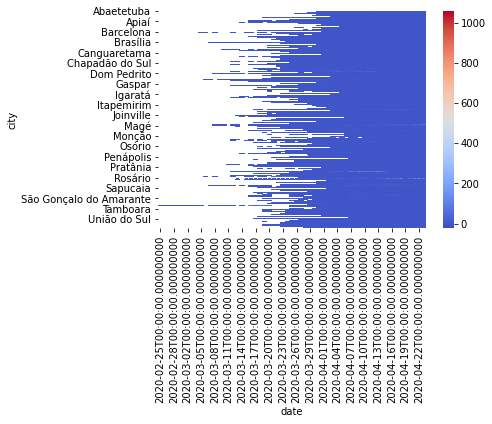

In [141]:
import seaborn as sns
from matplotlib.colors import LogNorm

latest['confirmed_log'] = np.log(latest['new_confirmed'])

# reshaping the data
latest_pt = pd.pivot_table(data=latest,
                    index='city',
                    values='new_confirmed',
                    columns='date')



# first attempt at heatmap
sns.heatmap(latest_pt, cmap='coolwarm')

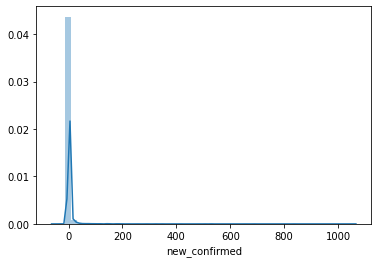

In [135]:
# It doesn't look very informative - the lower end of the distribution is crowding out information.
# What is the distribution?

sns.distplot(latest['new_confirmed'])
# That explains it!

In [144]:
latest['new_confirmed'].max()

1059